# <center>Композиции алгоритмов

Будем решать задачу кредитного скоринга.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [3]:
data = pd.read_csv('credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [5]:
table = impute_nan_with_median(data)

In [6]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [7]:
X.shape

(45063, 7)

Задайте решающее дерево, пользуясь встроенной функцией `DecisionTreeClassifier` с параметрами `random_state=17` и `class_weight='balanced'`.

In [8]:
dtc = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Используйте функцию `GridSearchCV` для выбора оптимального набора гиперпараметров для указанной задачи. В качестве метрики качества возьмите ROC AUC.

In [9]:
max_depth_values = [3, 5, 6, 7, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [10]:
clf2 = GridSearchCV(dtc, tree_params, scoring='roc_auc', cv=8, return_train_score=True)
clf2.fit(X, y)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 5, 6, 7, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [11]:
clf2.best_params_

{'max_depth': 6, 'max_features': 7}

In [12]:
clf2.best_score_

0.819625753230563

In [13]:
clf2.cv_results_['std_train_score'].mean()

0.0013690595109756838

Зафиксируйте кросс-валидацию с помощью функции `StratifiedKFold` на 5 разбиений с перемешиванием, `random_state=17`.

In [14]:
clf = GridSearchCV(dtc, tree_params, scoring='roc_auc', cv=StratifiedKFold(n_splits=5, random_state=17), return_train_score=True)
clf.fit(X, y)
clf.best_params_

{'max_depth': 7, 'max_features': 4}

Какое максимальное значение ROC AUC получилось? Является ли оценка на кросс-валидации надежной?

In [15]:
print('Максимальное значение ROC AUC = ', clf.best_score_)

Максимальное значение ROC AUC =  0.8201081676099699


In [16]:
clf.best_params_ 

{'max_depth': 7, 'max_features': 4}

In [17]:
clf.cv_results_['mean_test_score'].max()

0.8201081676099699

In [18]:
clf.cv_results_['std_train_score'].mean()

0.0019071010178781257

Оценку на кросс-валидации можно считать надежной, так как std выбранной метрики качества = 0.002

# Реализация бэггинга

Реализуйте свой собственный `BaggingClassifierCustom` с базовым классификатором `DecisionTreeClassifier`. По умолчанию будет 10 деревьев, предсказанные вероятности которых необходимо будет усреднить. 

Краткая спецификация: 
 - Используйте основу ниже.
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Это нужно для того, чтобы на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести.
 - Зафиксировав seed, сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов.
 - Найдите индексы объектов, которые не попали в обучающую выборку (опционально).
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `BaggingClassifierCustom` на выборке с нужным подмножеством объектов.
 - Метод `fit` возвращает текущий экземпляр класса `BaggingClassifierCustom`, то есть `self`.
 - В методе `predict_proba` опять нужен цикл по всем деревьям. Для тестовой выборки нужно сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.
 - В методе `oob_score` посчитайте качество полученного алгоритма на тех объектах, которые не попали в бутстрэп выборку с помощью метрики ROC AUC. (опционально)

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации?

In [8]:
from sklearn.base import BaseEstimator

class BaggingClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, random_state=17, max_features=4):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.max_features = max_features
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # в данном списке будем хранить объекты, которые не попали в обучающую выборку
        self.oob = {}
        
    def fit(self, X, y):
                
        X = pd.DataFrame(np.asarray(X))
        y = pd.DataFrame({'y' : np.asarray(y)})['y']
        for i in range(self.n_estimators):
            random.seed(self.random_state + i)
            indexes = [random.randint(0, X.shape[0]-1) for i in range(0, X.shape[0])]
            X_new = X.loc[indexes] # бутстрэп выборка 
            y_new = y.loc[indexes] 
            # Найдите индексы объектов, которые не попали в обучающую выборку (опционально)
            list_oob = list(set(list(range(X.shape[0])))^set(indexes))
            self.oob[i] = list_oob
            # Обучите дерево с теми же max_depth, max_features и random_state, что и у BaggingClassifierCustom на выборке с нужным подмножеством объектов.
            dtc = DecisionTreeClassifier(random_state=self.random_state, class_weight='balanced', max_depth=self.max_depth, max_features=self.max_features)
            dtc.fit(X_new, y_new)
            self.trees += [dtc]
        
        # Метод fit возвращает текущий экземпляр класса BaggingClassifierCustom, то есть self
        return self

    
    def predict_proba(self, X):
        
        all_pp = []
        # цикл по всем деревьям. 
        for tree in self.trees:
            all_pp.append(tree.predict_proba(X))  
        
        # Метод должен вернуть усреднение прогнозов по всем деревьям.
        pp = np.mean(all_pp, axis=0)
        return pp
    
    def predict(self, X):
        
        all_pp = []
        # цикл по всем деревьям. 
        for tree in self.trees:
            all_pp.append(tree.predict_proba(X))  
        
        # Метод должен вернуть усреднение прогнозов по всем деревьям.
        pp = np.mean(all_pp, axis=0)
        y_pred = [0 if i[0]==max(i) else 1 for i in pp ]
        return y_pred
    
        
    
    def oob_score(self, X, y):
        
        scores = []
        for i in range(len(self.oob)):
            tree = self.trees[i]
            y_pred = [0 if i[0]==max(i) else 1 for i in tree.predict_proba(X.loc[self.oob[i]]) ]
            score = roc_auc_score(y.loc[self.oob[i]], y_pred)  
            scores += [score]
        
        score = np.mean(scores)                 

        #  посчитайте качество полученного алгоритма на тех объектах, которые не попали в бутстрэп выборку с помощью метрики ROC AUC.
        return score
    

In [35]:
baggcc = BaggingClassifierCustom(n_estimators=3, max_depth=7, random_state=17, max_features=4)

In [36]:
baggcc.fit(X,y)

BaggingClassifierCustom(max_depth=7, max_features=4, n_estimators=3,
            random_state=17)

In [37]:
len(baggcc.trees)

3

In [38]:
baggcc.oob_score(X,y)

0.7465855365339699

In [13]:
baggcc = BaggingClassifierCustom(n_estimators=3, max_depth=7, random_state=17, max_features=4)
baggcc.fit(X,y)

cv1 = cross_validate(baggcc, X, y, cv=5, scoring=('roc_auc'),return_train_score=True)

print('Количество решающих деревьев:  ', baggcc.n_estimators, '\nCреднее значение ROC AUC на кросс-валидации  ', cv1['test_score'].mean())

Количество решающих деревьев:   3 
Cреднее значение ROC AUC на кросс-валидации   0.8329881693804309


In [40]:
baggcc2 = BaggingClassifierCustom(n_estimators=10, max_depth=7, random_state=17, max_features=4)
baggcc2.fit(X,y)

cv2 = cross_validate(baggcc2, X, y, cv=5, scoring=('roc_auc'),return_train_score=True)

print('Количество решающих деревьев:  ', baggcc2.n_estimators, '\nCреднее значение ROC AUC на кросс-валидации  ', cv2['test_score'].mean())

Количество решающих деревьев:   10 
Cреднее значение ROC AUC на кросс-валидации   0.8350352503339818


Построим график зависимости среднего значения ROC AUC на кросс-валидации от кол-ва решающих деревьев

In [14]:
xx = list(range(1, 22, 2)) 
# xx = [1, 3, 5, 7, 9, 11, 13]
yy = []
for x in xx:
    baggcc = BaggingClassifierCustom(n_estimators=x, max_depth=7, random_state=17, max_features=4)
    baggcc.fit(X,y)
    cv1 = cross_validate(baggcc, X, y, cv=5, scoring=('roc_auc'),return_train_score=True)
    score1 = cv1['test_score'].mean()
    yy += [score1]
    print('Рассчитано для ', x , 'деревьев')

Рассчитано для  1 деревьев
Рассчитано для  3 деревьев
Рассчитано для  5 деревьев
Рассчитано для  7 деревьев
Рассчитано для  9 деревьев
Рассчитано для  11 деревьев
Рассчитано для  13 деревьев
Рассчитано для  15 деревьев
Рассчитано для  17 деревьев
Рассчитано для  19 деревьев
Рассчитано для  21 деревьев


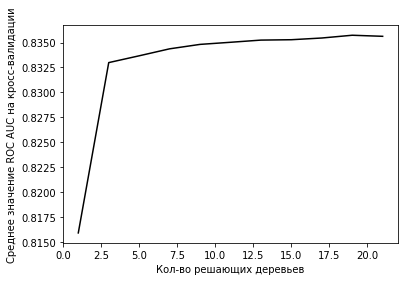

In [15]:
plt.xlabel("Кол-во решающих деревьев")
plt.ylabel("Среднее значение ROC AUC на кросс-валидации")
#plt.legend()
plt.plot(xx, yy, c = "black")
plt.show()

Сравните собственную реализацию с реализацией в sklearn. Для этого воспользуйтесь `BaggingClassifier(n_jobs=-1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Каким оказалось среднее значение ROC AUC на кросс-валидации? Чему равна out-of-bag оценка?

In [16]:
from sklearn.ensemble import BaggingClassifier

In [58]:
#model_libr = BaggingClassifier(n_jobs=-1, n_estimators=10, random_state=17, max_features=4)
dt = DecisionTreeClassifier(max_depth=7, class_weight='balanced')

In [59]:
#model_libr = BaggingClassifier(n_jobs=-1, n_estimators=10, random_state=17, max_features=4)
model_libr = BaggingClassifier(base_estimator=dt, n_jobs=-1, n_estimators=10, random_state=17, max_features=4)

model_libr.fit(X,y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=4,
         max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=17, verbose=0, warm_start=False)

In [60]:
cv_model = cross_validate(model_libr, X, y, cv=5, scoring=('roc_auc'),return_train_score=True)

print('Cреднее значение ROC AUC на кросс-валидации  ', cv_model['test_score'].mean())

Cреднее значение ROC AUC на кросс-валидации   0.8291354283835565


Ранее были найдены оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. С помощью `GridSearchCV (BaggingClassifier(random_state=17))` рассмотрите другие варианты. Какими теперь стали лучшие значения гиперпараметров и чему равен ROC AUC? 

In [53]:
max_depth_values = range(5, 14)
max_features_values = range(4, 8)

max_rocauc = 0
max_depth = 0
max_feat = 0

for depth in max_depth_values:
    for feature in max_features_values:        
        bagg_mod = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth, class_weight='balanced'), n_jobs=-1, n_estimators=10, random_state=17, max_features=feature)
        bagg_mod.fit(X,y)
        cv_bagg_mod = cross_validate(bagg_mod, X, y, cv=5, scoring=('roc_auc'), return_train_score=True)
        ro = cv_bagg_mod['test_score'].mean()
        if ro > max_rocauc:
            max_rocauc = ro
            max_depth = depth
            max_feat = feature

In [55]:
print('Максимальное значение ROC AUC = ', max_rocauc, 'достигается при max_depth = ', max_depth ,  ' и при max_features = ', max_feat)

Максимальное значение ROC AUC =  0.8315283144924669 достигается при max_depth =  8  и при max_features =  6


Примем cv=StratifiedKFold(n_splits=5, random_state=17)

In [57]:
max_depth_values = range(5, 14)
max_features_values = range(4, 8)

max_rocauc = 0
max_depth = 0
max_feat = 0

for depth in max_depth_values:
    for feature in max_features_values:        
        bagg_mod = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth, class_weight='balanced'), n_jobs=-1, n_estimators=10, random_state=17, max_features=feature)
        bagg_mod.fit(X,y)
        cv_bagg_mod = cross_validate(bagg_mod, X, y, cv=StratifiedKFold(n_splits=5, random_state=17), scoring=('roc_auc'), return_train_score=True)
        ro = cv_bagg_mod['test_score'].mean()
        if ro > max_rocauc:
            max_rocauc = ro
            max_depth = depth
            max_feat = feature
            
print('Максимальное значение ROC AUC = ', max_rocauc, 'достигается при max_depth = ', max_depth ,  ' и при max_features = ', max_feat)

Максимальное значение ROC AUC =  0.8315283144924669 достигается при max_depth =  8  и при max_features =  6


## Выводы по Бэггингу:
1. ROC AUC одного дерева 0.82
2. ROC AUC собственной реализации Бэггинга = **0.835** (кол-во решающих деревьев=10, max_depth=7,  max_features=4)
3. ROC AUC Бэггинга sklearn = 0.829 (кол-во решающих деревьев=10, max_depth=7,  max_features=4) - #те же параметры
4. Максимальный ROC AUC, которого удалось достичь для Бэггинка sklearn, = 0.831 (кол-во решающих деревьев=10, max_depth=8,  max_features=6)
**Итого:** собственная реализация лучше

# Реализация случайного леса

Теперь реализуйте случайный лес с помощью `DecisionTreeClassifier`.

Кроме индексов объектов теперь необходимо на каждом шаге алгоритма запоминать также индексы признаков, которые участвовали в обучении леса.

- Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`.
- Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков.
- В методе `predict_proba` у тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации?

In [93]:
from sklearn.base import BaseEstimator
 
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree ={}      

    
    def fit(self, X, y):
              
        X = pd.DataFrame(np.asarray(X))
        y = pd.DataFrame({'y' : np.asarray(y)})['y']
        for i in range(self.n_estimators):
            random.seed(self.random_state + i)
            indexes = [random.randint(0, X.shape[0]-1) for i in range(0, X.shape[0])]
            numb_feat = random.randint(1, self.max_features if self.max_features<=X.shape[1] else X.shape[1])
            indexes_features = random.sample(range(X.shape[1]), k=numb_feat)
            X_new = X.loc[indexes] # бутстрэп выборка 
            X_new = X_new[X_new.columns[indexes_features ]]
            y_new = y.loc[indexes]             
            
            self.feat_ids_by_tree[i] = indexes_features
            # Обучите дерево с теми же max_depth, max_features и random_state, что и у BaggingClassifierCustom на выборке с нужным подмножеством объектов.
            #dtc = DecisionTreeClassifier(random_state=self.random_state, max_depth=self.max_depth, max_features=self.max_features if self.max_features<=len(self.feat_ids_by_tree[i]) else len(self.feat_ids_by_tree[i]))
            dtc = DecisionTreeClassifier(random_state=self.random_state, max_depth=self.max_depth)
            dtc.fit(X_new, y_new)
            self.trees += [dtc]

        
        # Метод fit возвращает текущий экземпляр класса BaggingClassifierCustom, то есть self
        return self

            
    def predict_proba(self, X):
        
        all_pp = []
        # цикл по всем деревьям. 
        #for tree in self.trees:
        for i in range(len(self.trees)):
            all_pp.append(self.trees[i].predict_proba(X[X.columns[self.feat_ids_by_tree[i]]]))  
        
        # Метод должен вернуть усреднение прогнозов по всем деревьям.
        pp = np.mean(all_pp, axis=0)
        return pp
    
    def predict(self, X):
       
        all_pp = []
        # цикл по всем деревьям. 
        for tree in self.trees:
            all_pp.append(tree.predict_proba(X))  
        
        # Метод должен вернуть усреднение прогнозов по всем деревьям.
        pp = np.mean(all_pp, axis=0)
        y_pred = [0 if i[0]==max(i) else 1 for i in pp ]
        return y_pred
    

In [94]:
rfc_model = RandomForestClassifierCustom(n_estimators=15, max_depth=7, random_state=17, max_features=6)

In [95]:
rfc_model.fit(X, y)

RandomForestClassifierCustom(max_depth=7, max_features=6, n_estimators=15,
               random_state=17)

In [96]:
rfc_model.feat_ids_by_tree

{0: [4],
 1: [5, 0, 6, 3, 1, 2],
 2: [5, 0, 3, 2, 6, 1],
 3: [3, 0],
 4: [2],
 5: [4, 2, 0],
 6: [1, 2, 5, 0, 3, 4],
 7: [1, 3],
 8: [3, 5, 4, 6, 0],
 9: [0],
 10: [2],
 11: [1, 2, 4, 3],
 12: [2, 3, 6, 0, 1],
 13: [3, 4, 0, 6, 1],
 14: [0, 4, 5, 1, 3, 2]}

In [97]:
cv10 = cross_validate(rfc_model, X, y, cv=5, scoring=('roc_auc'),return_train_score=True)

print('Количество решающих деревьев:  ', rfc_model.n_estimators, '\nCреднее значение ROC AUC на кросс-валидации  ', cv10['test_score'].mean())

Количество решающих деревьев:   15 
Cреднее значение ROC AUC на кросс-валидации   0.8368277418341472


In [98]:
rfc_model2 = RandomForestClassifierCustom(n_estimators=35, max_depth=7, random_state=17, max_features=6)
rfc_model2.fit(X, y)
cv11 = cross_validate(rfc_model2, X, y, cv=5, scoring=('roc_auc'), return_train_score=True)

print('Количество решающих деревьев:  ', rfc_model2.n_estimators, '\nCреднее значение ROC AUC на кросс-валидации  ', cv11['test_score'].mean())

Количество решающих деревьев:   35 
Cреднее значение ROC AUC на кросс-валидации   0.8374815226482106


## Выводы по Случайному лесу:
1. Максимальный ROC AUC, которого удалось достичь для Случайного леса = **0.837**. Значение улучшилось на 0.002 относительно Бэггинга (ROC AUC Бэггинга = 0.835).

**Итог:** В дальнейшем используем алгоритм  Случайный лес.


*Рассмотрим библиотечную реализацию Случайного леса*

In [100]:
from sklearn.ensemble import RandomForestClassifier

rfc_model3 = RandomForestClassifier(n_estimators=35, max_depth=7, random_state=17, max_features=6)
rfc_model3.fit(X, y)
cv12 = cross_validate(rfc_model3, X, y, cv=5, scoring=('roc_auc'), return_train_score=True)

print('Количество решающих деревьев:  ', rfc_model3.n_estimators, '\nCреднее значение ROC AUC на кросс-валидации  ', cv12['test_score'].mean())

Количество решающих деревьев:   35 
Cреднее значение ROC AUC на кросс-валидации   0.8324532970597147


`Машинная реализация оказалась хуже, чем авторская.`